In [228]:
import numpy as np
import pickle  # 用 pickle 替代 cPickle
import gym
np.bool8 = np.bool_

In [229]:
import gym

In [230]:
env = gym.make("Pong-v4")
observation, _ = env.reset()

In [231]:
def show_img(observation):
    import numpy as np
    import matplotlib.pyplot as plt

    # 创建一个随机的 (210, 160, 3) 矩阵
    image = observation
    # image = prepro_1(observation)

    # 使用 matplotlib 显示图像
    plt.imshow(image)
    # plt.axis('off')  # 隐藏坐标轴
    plt.show()

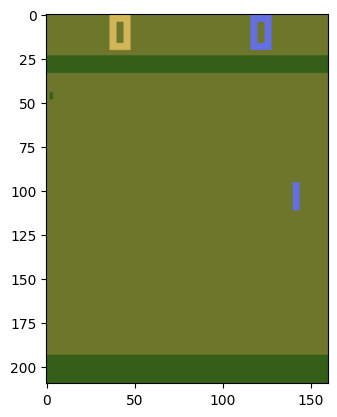

In [232]:
show_img(observation)

In [233]:
def prepro(I):
    """将 210x160x3 uint8 帧预处理为 6400 (80x80) 1D float 向量"""
    I = I[35:195]  # 裁剪
    I = I[::2, ::2, 0]  # 下采样因子为 2
    I[I == 144] = 0  # 删除背景类型 1
    I[I == 109] = 0  # 删除背景类型 2
    I[I != 0] = 1  # 其他设置为 1
    return I.astype(np.float32).ravel()

In [234]:
D = 6400
H = 200

In [235]:
from torch.optim import AdamW
from torch import nn

In [236]:
class Actor(nn.Module):
    
    
    def __init__(self, input_dim,output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim,200,bias=False)
        self.linear2 = nn.Linear(200,output_dim,bias=False)
        
       # Xavier 初始化 + 偏置归零
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)

        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return self.sigmoid(x)
    
    def sample_action(self,x):

        prob = self.forward(x)
#             prob = torch.clamp(prob, min=1e-8, max=1-1e-8)  # 关键修复
#             m = Bernoulli(prob)
#             action = m.sample().item()  # 1 表示向上，0 表示向下
#             return int(action) + 2
        action = 0 if prob.item() < np.random.uniform() else 1
        return prob, action

In [252]:
from collections import deque

class Memory:
    
    def __init__(self):
        self.queue = deque()
    
    def push(self,x,action,reward,done,y,prob):
        self.queue.append((x,action,reward,done,y,prob))
    
    def clear(self):
        self.queue.clear()
    
    def __len__(self):
        return len(self.deque)
    
    def sample(self):
        return zip(*self.queue)

In [253]:
class Value(nn.Module):
    
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim,200)
        self.linear2 = nn.Linear(200,output_dim)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [254]:
import torch

In [255]:
class Agent:
    
    def __init__(self):
        self.actor = Actor(D,1)
        self.value = Value(D,1) ## 评价当前x
        self.actor_optim = AdamW(self.actor.parameters(),lr=1e-3)
        self.value_optim = AdamW(self.value.parameters(),lr=1e-3)
        self.memory = Memory()
    
    
    def update(self):
        
        old_xs,old_actions,old_rewards,old_dones,old_ys,old_probs = self.memory.sample()
        ### 以上是历史数据，用来训练actor的
        
        old_xs = torch.tensor(old_xs)           # B,D
        old_probs = torch.cat(old_probs,dim=-1)
        old_actions = torch.LongTensor(old_actions)
        old_ys = torch.tensor(old_ys)           # B,1
        
        adding = 0
        returns = []
        for reward,done in reversed(list(zip(old_rewards,old_dones))):
            if done:
                adding = 0
            adding = adding * 0.99 + reward
            returns.insert(0,adding)
        
        returns = torch.tensor(returns) # B,1?
        returns -= returns.mean()
        returns /= (returns.std()+1e-5)
        
  
        probs = self.actor(old_xs) 
        log_probs = (1-old_ys)*torch.log(1-probs) + old_ys * torch.log(probs)
        actor_loss = (returns * log_probs).mean()
        print('loss',actor_loss,(returns * log_probs).sum(),len(returns))
        
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()
        
#         for _ in range(4):
#             values = self.value(old_xs) ### B,2
# #             vs = values.gather(dim=-1,index=old_actions.unsqueeze(dim=-1)) # B,1
#             ### 根据以前的动作来拟合评价标准
#             advantages = (returns - values).detach()
            
#             probs = self.actor(old_xs) ### 
#             ### 根据新的action选择
#             log_probs = (1-old_ys)*torch.log(1-probs) + old_ys * torch.log(probs) # B,1
#             old_logprobs = (1-old_ys)*torch.log(1-old_probs) + old_ys * torch.log(old_probs)
            
#             ratio = torch.exp(log_probs - old_logprobs)
#             clamp = torch.clamp(ratio,0.8,1.2)
#             actor_loss = -torch.min(advantages * clamp, advantages * ratio).mean()
#             value_loss = (returns - values).pow(2).mean()
        
            
#             self.actor_optim.zero_grad()
#             actor_loss.backward()
#             self.actor_optim.step()
            
#             self.value_optim.zero_grad()
#             value_loss.backward()
#             self.value_optim.step()
            
            
            
            
        self.memory.clear()

In [256]:
agent = Agent()

In [257]:
observation, _ = env.reset()
total_sum = 0
prev_x = None
while True:
    current_x = prepro(observation)
    gap = np.zeros_like(current_x) if prev_x is None else current_x - prev_x
    action_prob, action = agent.actor.sample_action(torch.from_numpy(gap))
    y = action ### 2,3
    observation, reward, terminated, truncated, info = env.step(int(action)+2)  # 更新为新的返回值
    prev_x = current_x
    total_sum += reward
    agent.memory.push(gap,action,reward,terminated,float(y),action_prob)
    if terminated or truncated:
        agent.update()
        print('total',total_sum)
        observation, _ = env.reset()
        total_sum = 0
        prev_x = None

loss tensor(0.0004, grad_fn=<MeanBackward0>) tensor(893.1169, grad_fn=<SumBackward0>) 1471
total -20.0
loss tensor(0.0002, grad_fn=<MeanBackward0>) tensor(246.0352, grad_fn=<SumBackward0>) 1218
total -20.0
loss tensor(0.0005, grad_fn=<MeanBackward0>) tensor(810.5383, grad_fn=<SumBackward0>) 1250
total -21.0
loss tensor(-0.0002, grad_fn=<MeanBackward0>) tensor(-186.8900, grad_fn=<SumBackward0>) 1075
total -21.0
loss tensor(-0.0006, grad_fn=<MeanBackward0>) tensor(-818.5081, grad_fn=<SumBackward0>) 1186
total -21.0
loss tensor(-0.0005, grad_fn=<MeanBackward0>) tensor(-812.3563, grad_fn=<SumBackward0>) 1257
total -21.0
loss tensor(-0.0003, grad_fn=<MeanBackward0>) tensor(-430.6109, grad_fn=<SumBackward0>) 1251
total -21.0
loss tensor(0.0002, grad_fn=<MeanBackward0>) tensor(343.3074, grad_fn=<SumBackward0>) 1261
total -21.0
loss tensor(-0.0032, grad_fn=<MeanBackward0>) tensor(-3940.3386, grad_fn=<SumBackward0>) 1105
total -21.0
loss tensor(-0.0017, grad_fn=<MeanBackward0>) tensor(-1748.442

loss tensor(-0.0051, grad_fn=<MeanBackward0>) tensor(-5200.9946, grad_fn=<SumBackward0>) 1005
total -21.0
loss tensor(0.0030, grad_fn=<MeanBackward0>) tensor(3658.4241, grad_fn=<SumBackward0>) 1102
total -21.0
loss tensor(-0.0020, grad_fn=<MeanBackward0>) tensor(-2063.6299, grad_fn=<SumBackward0>) 1005
total -21.0
loss tensor(0.0007, grad_fn=<MeanBackward0>) tensor(687.0309, grad_fn=<SumBackward0>) 1008
total -21.0
loss tensor(0.0073, grad_fn=<MeanBackward0>) tensor(7540.6499, grad_fn=<SumBackward0>) 1013
total -21.0
loss tensor(0.0064, grad_fn=<MeanBackward0>) tensor(6747.4512, grad_fn=<SumBackward0>) 1025
total -21.0
loss tensor(0.0046, grad_fn=<MeanBackward0>) tensor(4951.8921, grad_fn=<SumBackward0>) 1036
total -21.0
loss tensor(-0.0065, grad_fn=<MeanBackward0>) tensor(-6832.0693, grad_fn=<SumBackward0>) 1023
total -21.0
loss tensor(-0.0033, grad_fn=<MeanBackward0>) tensor(-3224.8845, grad_fn=<SumBackward0>) 994
total -21.0
loss tensor(0.0051, grad_fn=<MeanBackward0>) tensor(5206.3

loss tensor(0.0015, grad_fn=<MeanBackward0>) tensor(2846.3237, grad_fn=<SumBackward0>) 1395
total -20.0
loss tensor(-0.0058, grad_fn=<MeanBackward0>) tensor(-9946.4238, grad_fn=<SumBackward0>) 1313
total -20.0
loss tensor(0.0018, grad_fn=<MeanBackward0>) tensor(3536.9934, grad_fn=<SumBackward0>) 1388
total -20.0
loss tensor(-0.0007, grad_fn=<MeanBackward0>) tensor(-846.9476, grad_fn=<SumBackward0>) 1106
total -21.0
loss tensor(-0.0018, grad_fn=<MeanBackward0>) tensor(-2211.0715, grad_fn=<SumBackward0>) 1096
total -21.0
loss tensor(-0.0022, grad_fn=<MeanBackward0>) tensor(-3520.9465, grad_fn=<SumBackward0>) 1258
total -21.0
loss tensor(-0.0009, grad_fn=<MeanBackward0>) tensor(-1104.9182, grad_fn=<SumBackward0>) 1099
total -21.0
loss tensor(0.0002, grad_fn=<MeanBackward0>) tensor(176.9655, grad_fn=<SumBackward0>) 1012
total -21.0
loss tensor(0.0002, grad_fn=<MeanBackward0>) tensor(319.1348, grad_fn=<SumBackward0>) 1256
total -21.0
loss tensor(-0.0013, grad_fn=<MeanBackward0>) tensor(-134

loss tensor(-0.0044, grad_fn=<MeanBackward0>) tensor(-5054.8579, grad_fn=<SumBackward0>) 1077
total -21.0
loss tensor(0.0049, grad_fn=<MeanBackward0>) tensor(5087.5200, grad_fn=<SumBackward0>) 1019
total -21.0
loss tensor(-0.0021, grad_fn=<MeanBackward0>) tensor(-2244.4966, grad_fn=<SumBackward0>) 1022
total -21.0
loss tensor(0.0044, grad_fn=<MeanBackward0>) tensor(4543.6680, grad_fn=<SumBackward0>) 1019
total -21.0
loss tensor(-0.0054, grad_fn=<MeanBackward0>) tensor(-5655.7876, grad_fn=<SumBackward0>) 1022
total -21.0
loss tensor(-0.0019, grad_fn=<MeanBackward0>) tensor(-1961.2551, grad_fn=<SumBackward0>) 1029
total -21.0
loss tensor(0.0030, grad_fn=<MeanBackward0>) tensor(3042.0649, grad_fn=<SumBackward0>) 1004
total -21.0
loss tensor(0.0097, grad_fn=<MeanBackward0>) tensor(9865.9609, grad_fn=<SumBackward0>) 1006
total -21.0
loss tensor(-0.0068, grad_fn=<MeanBackward0>) tensor(-7103.9976, grad_fn=<SumBackward0>) 1023
total -21.0
loss tensor(-0.0017, grad_fn=<MeanBackward0>) tensor(-

loss tensor(-0.0014, grad_fn=<MeanBackward0>) tensor(-1471.2625, grad_fn=<SumBackward0>) 1021
total -21.0
loss tensor(-0.0010, grad_fn=<MeanBackward0>) tensor(-1068.0184, grad_fn=<SumBackward0>) 1016
total -21.0
loss tensor(-0.0010, grad_fn=<MeanBackward0>) tensor(-997.7277, grad_fn=<SumBackward0>) 1021
total -21.0
loss tensor(0.0047, grad_fn=<MeanBackward0>) tensor(4773.5464, grad_fn=<SumBackward0>) 1010
total -21.0
loss tensor(0.0050, grad_fn=<MeanBackward0>) tensor(5198.6304, grad_fn=<SumBackward0>) 1024
total -21.0
loss tensor(0.0003, grad_fn=<MeanBackward0>) tensor(333.6965, grad_fn=<SumBackward0>) 1019
total -21.0
loss tensor(-0.0009, grad_fn=<MeanBackward0>) tensor(-931.3029, grad_fn=<SumBackward0>) 1003
total -21.0
loss tensor(0.0034, grad_fn=<MeanBackward0>) tensor(3523.6863, grad_fn=<SumBackward0>) 1019
total -21.0
loss tensor(0.0008, grad_fn=<MeanBackward0>) tensor(826.4037, grad_fn=<SumBackward0>) 1016
total -21.0
loss tensor(-0.0009, grad_fn=<MeanBackward0>) tensor(-920.69

loss tensor(9.6269e-05, grad_fn=<MeanBackward0>) tensor(101.5382, grad_fn=<SumBackward0>) 1027
total -21.0
loss tensor(0.0005, grad_fn=<MeanBackward0>) tensor(571.7002, grad_fn=<SumBackward0>) 1029
total -21.0
loss tensor(0.0056, grad_fn=<MeanBackward0>) tensor(5628.9453, grad_fn=<SumBackward0>) 1006
total -21.0
loss tensor(-0.0003, grad_fn=<MeanBackward0>) tensor(-276.9620, grad_fn=<SumBackward0>) 1021
total -21.0
loss tensor(-0.0021, grad_fn=<MeanBackward0>) tensor(-2265.5554, grad_fn=<SumBackward0>) 1028
total -21.0
loss tensor(0.0011, grad_fn=<MeanBackward0>) tensor(1109.7681, grad_fn=<SumBackward0>) 1020
total -21.0
loss tensor(0.0027, grad_fn=<MeanBackward0>) tensor(2858.2505, grad_fn=<SumBackward0>) 1023
total -21.0
loss tensor(0.0016, grad_fn=<MeanBackward0>) tensor(1622.8193, grad_fn=<SumBackward0>) 1015
total -21.0
loss tensor(0.0002, grad_fn=<MeanBackward0>) tensor(216.2751, grad_fn=<SumBackward0>) 1028
total -21.0
loss tensor(0.0042, grad_fn=<MeanBackward0>) tensor(4410.201

KeyboardInterrupt: 

In [ ]:
for k in agent.actor.parameters():
    print(k)

In [ ]:
torch.save(model.state_dict(),'model.pt')

In [ ]:
!ls model.pt

In [ ]:
env = gym.make("Pong-v4",render_mode="human")
observation, _ = env.reset()

In [19]:
model = MLP(D,1)

In [20]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
prev_x = None
while True:
    current_x = prepro(observation)
    gap = np.zeros_like(current_x) if prev_x is None else current_x - prev_x
    prob = model(torch.from_numpy(gap))
    action = 2 if prob < 0.5 else 3
    observation, reward, terminated, truncated, info = env.step(action)  # 更新为新的返回值
    prev_x = current_x
    if terminated:
        observation, _ = env.reset()
        prev_x = None

2025-04-12 19:22:21.302 python[26815:139541057] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-12 19:22:21.302 python[26815:139541057] +[IMKInputSession subclass]: chose IMKInputSession_Modern
